## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (84,84,3)
IMAGE_DIMS = (56,56,3)
#IMAGE_DIMS = (42,42,3)
#IMAGE_DIMS = (26,26,3)

INPUT_DATASET_NAME = 'lion-patches-0px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights-medium1.h5'
SAVE_MODEL_FILE = None
#SAVE_MODEL_FILE = OUTPUT_DIR + 'last-model-medium1-class0-84x84.yml'
LOAD_WEIGHTS_FILE = SAVE_WEIGHTS_FILE
LOAD_MODEL_FILE = None

RECREATE_OUTPUT_DIR = False
RUN_TRAINING = True

Y_CHANGE = None
Y_CHANGE = ((0,5),(1,5),(3,5),(4,5))
TRAIN_WEIGHT = (1,1,1,1,1,1)
TEST_WEIGHT = (1,1,1,1,1,10)
TRAIN_EPOCHS = 10
INPUT_RANGE = 1

BATCH_SIZE=48

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-06-09 00:50:18,951 INFO Output dirs created


### Prepare train, validate and test data flows

In [4]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

#used for image augmentation (creating new images for balancing)
image_augmentation_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

#applied to all images during training
image_randomize_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TRAIN_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=0.7,
                                                         change_y=Y_CHANGE)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.7, end_ratio=0.85,
                                                         change_y=Y_CHANGE)
logger.info('valid size=' + str(valid_balance_generator.size) + ' batches=' + str(valid_balance_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.85, end_ratio=1,
                                                         change_y=Y_CHANGE)
logger.info('test size=' + str(test_balance_generator.size) + ' batches=' + str(test_balance_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-06-09 00:50:19,081 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-56-56.h5 as input
2017-06-09 00:50:19,106 INFO preparing train data
2017-06-09 00:50:19,114 INFO loading input data for class distribution analysis...
2017-06-09 00:50:19,119 INFO loading Y from raw dataset
2017-06-09 00:50:19,126 INFO > [started] generator dump...


2263/2263

2017-06-09 00:50:20,121 INFO > [done]    generator dump (995.551 ms)
2017-06-09 00:50:20,134 INFO raw sample class distribution
2017-06-09 00:50:20,140 INFO 0: 0
2017-06-09 00:50:20,147 INFO 1: 0
2017-06-09 00:50:20,152 INFO 2: 675
2017-06-09 00:50:20,158 INFO 3: 0
2017-06-09 00:50:20,163 INFO 4: 0
2017-06-09 00:50:20,169 INFO 5: 1588
2017-06-09 00:50:20,174 INFO overall output samples per class: 1350
2017-06-09 00:50:20,180 INFO augmentation/undersampling ratio per class
2017-06-09 00:50:20,185 INFO SETUP FLOW 0 0.7
2017-06-09 00:50:20,190 INFO calculating source range according to start/end range of the desired output..
2017-06-09 00:50:20,196 INFO output distribution for this flow
2017-06-09 00:50:20,201 INFO 0: 0 (0.00)
2017-06-09 00:50:20,206 INFO 1: 0 (0.00)
2017-06-09 00:50:20,211 INFO 2: 944 (2.00)
2017-06-09 00:50:20,216 INFO 3: 0 (0.00)
2017-06-09 00:50:20,222 INFO 4: 0 (0.00)
2017-06-09 00:50:20,227 INFO 5: 944 (0.85)
2017-06-09 00:50:20,240 INFO source range: 0-1558 (1558)


2263/2263

2017-06-09 00:50:21,116 INFO > [done]    generator dump (844.179 ms)
2017-06-09 00:50:21,129 INFO raw sample class distribution
2017-06-09 00:50:21,134 INFO 0: 0
2017-06-09 00:50:21,139 INFO 1: 0
2017-06-09 00:50:21,145 INFO 2: 675
2017-06-09 00:50:21,150 INFO 3: 0
2017-06-09 00:50:21,155 INFO 4: 0
2017-06-09 00:50:21,161 INFO 5: 1588
2017-06-09 00:50:21,166 INFO overall output samples per class: 1350
2017-06-09 00:50:21,172 INFO augmentation/undersampling ratio per class
2017-06-09 00:50:21,177 INFO SETUP FLOW 0.7 0.85
2017-06-09 00:50:21,182 INFO calculating source range according to start/end range of the desired output..
2017-06-09 00:50:21,187 INFO output distribution for this flow
2017-06-09 00:50:21,194 INFO 0: 0 (0.00)
2017-06-09 00:50:21,199 INFO 1: 0 (0.00)
2017-06-09 00:50:21,207 INFO 2: 202 (2.00)
2017-06-09 00:50:21,211 INFO 3: 0 (0.00)
2017-06-09 00:50:21,218 INFO 4: 0 (0.00)
2017-06-09 00:50:21,223 INFO 5: 2025 (8.50)
2017-06-09 00:50:21,236 INFO source range: 1647-1947 

2263/2263

2017-06-09 00:50:22,110 INFO > [done]    generator dump (840.838 ms)
2017-06-09 00:50:22,123 INFO raw sample class distribution
2017-06-09 00:50:22,129 INFO 0: 0
2017-06-09 00:50:22,135 INFO 1: 0
2017-06-09 00:50:22,140 INFO 2: 675
2017-06-09 00:50:22,146 INFO 3: 0
2017-06-09 00:50:22,151 INFO 4: 0
2017-06-09 00:50:22,157 INFO 5: 1588
2017-06-09 00:50:22,163 INFO overall output samples per class: 1350
2017-06-09 00:50:22,168 INFO augmentation/undersampling ratio per class
2017-06-09 00:50:22,173 INFO SETUP FLOW 0.85 1
2017-06-09 00:50:22,179 INFO calculating source range according to start/end range of the desired output..
2017-06-09 00:50:22,183 INFO output distribution for this flow
2017-06-09 00:50:22,188 INFO 0: 0 (0.00)
2017-06-09 00:50:22,195 INFO 1: 0 (0.00)
2017-06-09 00:50:22,200 INFO 2: 202 (2.00)
2017-06-09 00:50:22,205 INFO 3: 0 (0.00)
2017-06-09 00:50:22,210 INFO 4: 0 (0.00)
2017-06-09 00:50:22,215 INFO 5: 2025 (8.50)
2017-06-09 00:50:22,228 INFO source range: 1948-2261 (3

2017-06-09 00:50:22,277 INFO BALANCE GENERATOR DATA
2017-06-09 00:50:22,285 INFO > [started] generator dump...
2017-06-09 00:50:22,291 INFO starting new flow...


1920/1889

2017-06-09 00:50:29,984 INFO > [done]    generator dump (7699.216 ms)
2017-06-09 00:50:29,991 INFO y (1889, 6)
2017-06-09 00:50:30,003 INFO [  0   0 986   0   0 903]
2017-06-09 00:50:30,008 INFO starting new flow...
2017-06-09 00:50:30,093 INFO showing 48 images
2017-06-09 00:50:30,100 INFO > [started] generating image patches. rows=5; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:725: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(image_labels!=None):


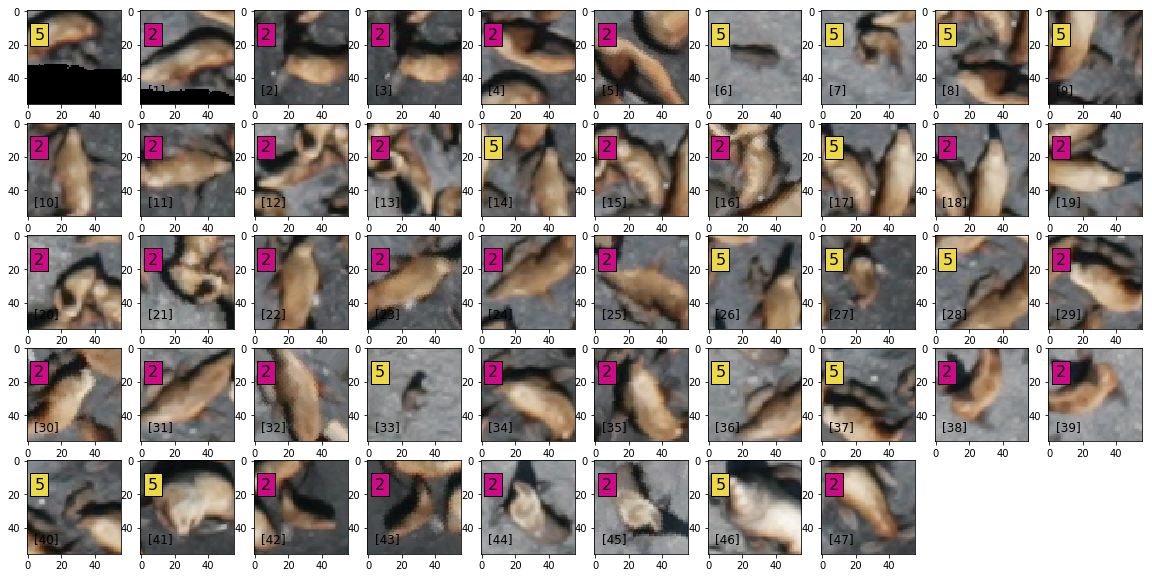

2017-06-09 00:50:45,691 INFO > [done]    generating image patches. rows=5; cols=10 (15590.509 ms)


In [5]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator, train_balance_generator.size, x=False, y=True)
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

for xs,ys in train_balance_generator.flow():
    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
    break

### Prepare CNN model

In [6]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)
else:
    model = lions.convnet_medium1_lion_keras(IMAGE_DIMS)
    logger.info('loaded model from function convnet_medium1_lion_keras')
    

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    model.load_weights(LOAD_WEIGHTS_FILE)
    logger.info('Loaded model weights from ' + LOAD_WEIGHTS_FILE)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])    
logger.info('Model prepared')

2017-06-09 00:50:45,747 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
  model.add(convolutional.Conv2D(64, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same', i

## Train model

In [7]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator,
                  steps_per_epoch = train_balance_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_balance_generator.flow(), 
                  validation_steps = valid_balance_generator.nr_batches,
                  verbose = 1)

    if(SAVE_MODEL_FILE!=None):
        with open(SAVE_MODEL_FILE, 'w') as model_file:
            model_file.write(model.to_yaml())
            logger.info('Saved last model to ' + SAVE_MODEL_FILE)
    
    if(SAVE_WEIGHTS_FILE!=None):
        model.save_weights(SAVE_WEIGHTS_FILE)
        logger.info('Saved last weights to ' + SAVE_WEIGHTS_FILE)


2017-06-09 00:50:46,293 INFO Starting CNN training...


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-09 00:50:46,691 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-09 00:50:46,720 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-09 00:50:46,734 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-09 00:50:46,762 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-09 00:50:46,781 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-09 00:50:46,804 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-09 00:50:46,817 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-09 00:50:46,848 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-09 00:50:46,868 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-09 00:50:47,469 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-09 00:50:47,484 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-09 00:50:47,513 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-09 00:50:47,537 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-09 00:50:47,578 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-09 00:50:47,590 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-09 00:50:47,617 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-09 00:50:47,638 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-09 00:50:47,660 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-09 00:50:47,675 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-09 00:50:47,704 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-09 00:50:47,724 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-09 00:50:47,762 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-09 00:50:47,774 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-09 00:50:47,798 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=40, verbose=1, validation_steps=47, callbacks=[<keras.ca..., epochs=10)`


Epoch 1/10
Epoch 1/10
34/40 [========================>.....] - ETA: 20s - loss: 0.8035 - acc: 0.5196 

KeyboardInterrupt: 

### Epoch accuracy/loss

In [ ]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

In [ ]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=lions.CLASS_LABELS)

In [ ]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 50, model)

In [ ]:
a = np.array([[1,0,0,0,1],[1,0,0,0,1]])
print(np.sum(a, axis=0))